# Homework 2

In [2]:
pip install psycopg2-binary


Note: you may need to restart the kernel to use updated packages.


# For checking HW 3 and HW 4 launch all cells from beginning or just watch the result of already launched cells

In [3]:
# import packages

import psycopg2
import getpass
import numpy as np
import datetime
import time
import pandas as pd
import dateutil.relativedelta as dr

# connect with database
a = input('User of database: ' )
b = input('Name of database: ' )
c = input('Host: ' )
d = input('Port: ' )
conn=psycopg2.connect(user=a, 
                      database=b, 
                      host=c,
                      port=d,
                      password=getpass.getpass('Insert password'))

# check parameters

print(conn.get_dsn_parameters())

User of database: postgres
Name of database: postgres
Host: localhost
Port: 5432
Insert password········
{'user': 'postgres', 'dbname': 'postgres', 'host': 'localhost', 'port': '5432', 'tty': '', 'options': '', 'sslmode': 'prefer', 'sslcompression': '0', 'krbsrvname': 'postgres', 'target_session_attrs': 'any'}


In [5]:
# extract data from bond_description and quotes

query = """SELECT *
            FROM (SELECT MAX("CPN") AS "CPN", "ISIN", max("BUYBACKDATE") AS "BUYBACKDATE",
                  max("BUYBACKPRICE") AS "BUYBACKPRICE"
                  FROM public.quotes  
                  GROUP BY "ISIN") AS a
            INNER JOIN(SELECT "ISINCode", "FaceValue", "HaveOffer", "AmortisedMty", 
                       "CouponPerYear", "NumCoupons", "EndMtyDate", "CouponType", "IssuerName"
                       FROM public.bond_description 
                       WHERE "Status"!='Погашен') AS b
            ON a."ISIN" = b."ISINCode";"""

# read query in python

data = pd.read_sql_query(query, conn) 

# Extract more specified data 
data.drop(['ISINCode'], axis=1)
data.BUYBACKPRICE = data.BUYBACKPRICE.fillna(0)
data = data[~data.CPN.isna()].reset_index(drop = True)
data = data[data.CPN != 0]
data = data[data.CouponPerYear > 0]

# if you had timestamp format in any of extracted fields so change format to date
# in my case it was only buybackdate

data.BUYBACKDATE = data.BUYBACKDATE
data.head()

,CPN,ISIN,BUYBACKDATE,BUYBACKPRICE,ISINCode,FaceValue,HaveOffer,AmortisedMty,CouponPerYear,NumCoupons,EndMtyDate,CouponType,IssuerName
0,42.3836,RU000A0JUPY1,2017-06-23,$100.00,RU000A0JUPY1,1000.0,True,False,2,20,2024-06-14,Переменный,Банк Зенит
1,43.1315,RU000A0JUEE7,2019-01-22,$100.00,RU000A0JUEE7,1000.0,True,False,2,20,2024-01-16,Переменный,ВЭБ-лизинг
2,66.0700,RU000A0JTY40,2016-06-01,$100.00,RU000A0JTY40,1000.0,True,False,2,10,2018-05-30,Переменный,Банк Зенит
3,59.3400,RU000A0JV227,2017-12-07,$100.00,RU000A0JV227,1000.0,True,False,2,20,2024-11-28,Переменный,Роснефть НК
4,59.8356,RU000A0JT8N3,2016-10-21,$100.00,RU000A0JT8N3,1000.0,True,False,2,14,2019-10-18,Переменный,Почта России


In [4]:
# function to count coupon payments

def coupon_count(coup_str):
    full_matrix = pd.DataFrame() # local var
    end_date = coup_str.BUYBACKDATE.values[0] if coup_str.BUYBACKDATE.values[0] is not None else coup_str.EndMtyDate.values[0]
    a = int(coup_str.CouponPerYear.values[0])
    b = float(coup_str.NumCoupons.values[0])
    types = True
    if coup_str.CPN is not None or coup_str.CPN != 0:
        if coup_str.AmortisedMty.astype(str).values[0] == 'False':
            types = False
            amount = coup_str.CPN.values[0]
            for j in np.linspace((b - 1) / a, 0, b):
                date = coup_str.EndMtyDate.values[0] - dr.relativedelta(days = round(365.25 * j))
                if date >= end_date and coup_str.EndMtyDate.values[0] != end_date :
                    date = end_date
                    amount = coup_str.BUYBACKPRICE.values[0]
                    full_matrix = pd.concat([full_matrix, pd.DataFrame({date.strftime("%Y-%m-%d"): [amount]})], axis = 1)
                    break
                elif date >= end_date and coup_str.EndMtyDate.values[0] == end_date:
                    date = end_date
                    amount += coup_str.FaceValue.values[0]
                    full_matrix = pd.concat([full_matrix, pd.DataFrame({date.strftime("%Y-%m-%d"): [amount]})], axis = 1)
                    break
                full_matrix = pd.concat([full_matrix, pd.DataFrame({date.strftime("%Y-%m-%d"): [amount]})], axis = 1)
                amount = coup_str.CPN.values[0]
        else:
            percent = float(coup_str.CPN.values[0]) / float(coup_str.FaceValue.values[0])
            index = (b - 1)
            face = coup_str.FaceValue.values[0]
            while index >= 0:
                amount = percent * face
                date = coup_str.EndMtyDate.values[0] - dr.relativedelta(days = round(365.25*index/a))
                if date >= end_date and coup_str.EndMtyDate.values[0] != end_date :
                    date = end_date
                    amount = coup_str.BUYBACKPRICE.values[0]
                    full_matrix = pd.concat([full_matrix, pd.DataFrame({date.strftime("%Y-%m-%d"): [amount]})], axis = 1)
                    break
                elif date >= end_date and coup_str.EndMtyDate.values[0] == end_date:
                    date = end_date
                    amount = face
                    full_matrix = pd.concat([full_matrix, pd.DataFrame({date.strftime("%Y-%m-%d"): [amount]})], axis = 1)
                    break
                full_matrix = pd.concat([full_matrix, pd.DataFrame({date.strftime("%Y-%m-%d"): [amount]})], axis = 1)
                index -= 1
                face = face * (1 - percent)
    my_index = pd.MultiIndex.from_tuples([(coup_str.ISIN.values[0], 'Amortised' if types else 'Not Amortised'
                                           , coup_str.IssuerName.values[0] )], names=['ISIN', 'Amortisation', 'Issuer'])
    full_matrix = pd.DataFrame(full_matrix.values, index = my_index, columns = full_matrix.columns)
    return full_matrix

In [5]:
# full_matrix contains coupon payments for all the emitents
# global var:

full_matrix = pd.DataFrame()

# fill in full_matrix

for i in data.iterrows():
    full_matrix = pd.concat([full_matrix, coupon_count(pd.DataFrame(i[1]).T)], sort = True)
    
# example
full_matrix.fillna(0).head(20)

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  del sys.path[0]


,,,2006-08-19,2006-10-06,2007-01-05,2007-02-18,2007-04-06,2007-06-11,2007-06-15,2007-06-16,2007-07-07,2007-08-11,...,2031-03-21,2031-09-20,2032-03-21,2032-09-19,2033-03-21,2033-09-20,2034-03-21,2034-09-20,2035-03-21,2035-09-20
ISIN,Amortisation,Issuer,,,,,,,,,,,,,,,,,,,,,
RU000A0JRYJ0,Not Amortised,Автодор ГК,0.0,0.0000,0.0000,0.0,0.0000,0.0,0.0,0.00,0.0000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
RU000A0JTG34,Amortised,Воронежская Обл Прав,0.0,0.0000,0.0000,0.0,0.0000,0.0,0.0,0.00,0.0000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
RU000A0JU823,Amortised,Воронежская Обл Прав,0.0,0.0000,0.0000,0.0,0.0000,0.0,0.0,0.00,0.0000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
RU000A0JUWK6,Amortised,Воронежская Обл Прав,0.0,0.0000,0.0000,0.0,0.0000,0.0,0.0,0.00,0.0000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
RU000A0JS1E8,Amortised,Вологодская Обл Прав,0.0,0.0000,0.0000,0.0,0.0000,0.0,0.0,0.00,0.0000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
RU000A0JTF68,Amortised,Вологодская Обл Прав,0.0,0.0000,0.0000,0.0,0.0000,0.0,0.0,0.00,0.0000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
RU000A0JV3M2,Amortised,Волжский Адм,0.0,0.0000,0.0000,0.0,0.0000,0.0,0.0,0.00,0.0000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
RU000A0JRGR0,Amortised,Волгоградская Обл Адм,0.0,0.0000,0.0000,0.0,0.0000,0.0,0.0,0.00,0.0000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
RU000A0JUP89,Amortised,Волгоградская Обл Адм,0.0,0.0000,0.0000,0.0,0.0000,0.0,0.0,0.00,0.0000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
# check
print(full_matrix.values[0].T != 'nan')
print(full_matrix.shape) # table: 500 rows, 2230 columns


True
(500, 2230)


C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  


In [7]:
# from the given date to the end
import datetime
from datetime import datetime, timedelta, date
def from_date_matrix(issuer_name, date):
    
    spec_payments = pd.DataFrame()
    for i in range(0, len(full_matrix.xs(str(issuer_name), level = 2).dropna(axis = 1, how = 'all').fillna(0).columns)):
        date_size = int(full_matrix.xs(str(issuer_name), level = 2).dropna(axis = 1, \
        how = 'all').fillna(0).columns[i].split('-')[0]) * 365 + int(full_matrix.xs(str(issuer_name), \
        level = 2).dropna(axis = 1, how = 'all').fillna(0).columns[i].split('-')[1]) * 365 / 12 + \
        int(full_matrix.xs(str(issuer_name), level = 2).dropna(axis = 1, how = 'all').fillna(0).columns[i].split('-')[2])
        if int(date.split('-')[0]) * 365 + int(date.split('-')[1]) * 365 / 12 + int(date.split('-')[2]) < date_size:
            data = full_matrix.xs(str(issuer_name), level = 2).dropna(axis = 1, how = 'all').fillna(0).iloc[:, i:i+1]
            spec_payments = pd.concat([spec_payments, data], axis = 1)
    return spec_payments

In [8]:
# example
# insert date in format yyyy-mm-dd
from_date_matrix('Банк ВТБ','2010-01-01')


,,2010-01-05,2010-04-06,2010-07-06,2010-10-06,2011-01-05,2011-04-06,2011-07-07,2011-10-06,2012-01-05,2012-04-06,...,2016-01-05,2016-01-06,2016-01-19,2016-02-16,2016-03-24,2016-03-30,2016-06-23,2016-06-28,2016-06-29,2016-07-08
ISIN,Amortisation,,,,,,,,,,,,,,,,,,,,,
RU000A0JTK20,Not Amortised,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0,20.32,0.0,0.00,0.00,0.00,0.0,0.00,0.0
RU000A0JTN01,Not Amortised,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0,0.00,19.7,0.00,0.00,0.00,0.0,0.00,0.0
RU000A0JNGU3,Not Amortised,30.2918,30.2918,30.2918,30.2918,30.2918,30.2918,30.2918,30.2918,30.2918,30.2918,...,30.2918,100.0,0.00,0.0,0.00,0.00,0.00,0.0,0.00,0.0
RU000A0JUQE1,Not Amortised,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0,0.00,0.0,23.81,0.00,23.81,100.0,0.00,0.0
RU000A0JU773,Not Amortised,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0,0.00,0.0,0.00,35.28,0.00,0.0,35.28,100.0
RU000A0JV3Q3,Not Amortised,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0,0.00,0.0,0.00,0.00,0.00,0.0,0.00,0.0


In [9]:
# payments on specified date
def on_spec_date(issuer_name, date):
    on_spec_date_payments = pd.DataFrame()
    for i in range(0,len(full_matrix.xs(str(issuer_name), level = 2).dropna(axis = 1, how = 'all').fillna(0).columns)):
        date_size = int(full_matrix.xs(str(issuer_name), level = 2).dropna(axis = 1, \
        how = 'all').fillna(0).columns[i].split('-')[0]) * 365 + int(full_matrix.xs(str(issuer_name),\
        level = 2).dropna(axis = 1, how = 'all').fillna(0).columns[i].split('-')[1]) * 365 / 12 + \
        int(full_matrix.xs(str(issuer_name), level = 2).dropna(axis = 1, how='all').fillna(0).columns[i].split('-')[2])
        if int(date.split('-')[0]) * 365 + int(date.split('-')[1]) * 365 / 12 + int(date.split('-')[2]) == date_size:
            data = full_matrix.xs(str(issuer_name), level = 2).dropna(axis = 1, how = 'all').fillna(0).iloc[:, i:i+1]
            on_spec_date_payments = pd.concat([on_spec_date_payments, data], axis = 1)
    return on_spec_date_payments

In [10]:
on_spec_date('Банк ВТБ','2016-02-16')

,,2016-02-16
ISIN,Amortisation,
RU000A0JTK20,Not Amortised,0.0
RU000A0JTN01,Not Amortised,19.7
RU000A0JNGU3,Not Amortised,0.0
RU000A0JUQE1,Not Amortised,0.0
RU000A0JU773,Not Amortised,0.0
RU000A0JV3Q3,Not Amortised,0.0


In [11]:
# from the beginning date to today

import datetime
acctual_date = datetime.datetime.now().strftime("%Y-%m-%d")

def from_date_to_today(issuer_name):
    from_date_to_today_payments = pd.DataFrame()
    for i in range(0, len(full_matrix.xs(str(issuer_name), level = 2).dropna(axis = 1, how = 'all').fillna(0).columns)):
        date_size = int(full_matrix.xs(str(issuer_name), level = 2).dropna(axis = 1, \
        how = 'all').fillna(0).columns[i].split('-')[0]) * 365 + \
        int(full_matrix.xs(str(issuer_name), level = 2).dropna(axis = 1, how = 'all').fillna(0).columns[i].split('-')[1]) * 365/12 \
        + int(full_matrix.xs(str(issuer_name), level = 2).dropna(axis = 1, how = 'all').fillna(0).columns[i].split('-')[2])
        if int(datetime.datetime.now().strftime("%Y-%m-%d").split('-')[0]) * 365 + \
        int(datetime.datetime.now().strftime("%Y-%m-%d").split('-')[1]) * 365/12 + \
        int(datetime.datetime.now().strftime("%Y-%m-%d").split('-')[2]) > date_size:
            data = full_matrix.xs(str(issuer_name), level = 2).dropna(axis = 1, how = 'all').fillna(0).iloc[:, i:i+1]
            from_date_to_today_payments = pd.concat([from_date_to_today_payments, data], axis = 1)
    return from_date_to_today_payments

In [12]:
from_date_to_today('Россельхозбанк')

,,2007-08-11,2008-02-10,2008-03-28,2008-08-10,2008-09-27,2008-12-04,2009-02-09,2009-03-28,2009-05-28,2009-06-05,...,2019-04-01,2019-05-01,2019-06-28,2019-07-01,2019-07-31,2019-09-28,2019-10-01,2019-10-04,2019-10-07,2019-10-30
ISIN,Amortisation,,,,,,,,,,,,,,,,,,,,,
RU000A0JP2G4,Not Amortised,46.12,46.12,0.0000,46.12,0.0000,0.00,46.12,0.0000,0.00,0.00,...,0.000,0.0,0.000,0.000,0.0,0.000,0.000,0.0,0.0,0.0
RU000A0JUPQ7,Not Amortised,0.00,0.00,0.0000,0.00,0.0000,0.00,0.00,0.0000,0.00,0.00,...,0.000,0.0,0.000,0.000,0.0,0.000,0.000,0.0,0.0,0.0
RU000A0JUQ05,Not Amortised,0.00,0.00,0.0000,0.00,0.0000,0.00,0.00,0.0000,0.00,0.00,...,0.000,0.0,0.000,0.000,0.0,0.000,0.000,0.0,0.0,0.0
RU000A0JPF47,Not Amortised,0.00,0.00,61.5808,0.00,61.5808,0.00,0.00,61.5808,0.00,0.00,...,0.000,0.0,0.000,0.000,0.0,0.000,0.000,0.0,0.0,0.0
RU000A0JPMT8,Not Amortised,0.00,0.00,0.0000,59.34,0.0000,0.00,59.34,0.0000,0.00,0.00,...,0.000,0.0,0.000,0.000,0.0,0.000,0.000,0.0,0.0,0.0
RU000A0JPTE5,Not Amortised,0.00,0.00,0.0000,0.00,0.0000,34.41,0.00,0.0000,0.00,34.41,...,0.000,0.0,0.000,0.000,0.0,0.000,0.000,0.0,0.0,0.0
RU000A0JQ1H3,Not Amortised,0.00,0.00,0.0000,0.00,0.0000,0.00,0.00,0.0000,67.32,0.00,...,0.000,0.0,0.000,0.000,0.0,0.000,0.000,0.0,0.0,0.0
RU000A0JQK64,Not Amortised,0.00,0.00,0.0000,0.00,0.0000,0.00,0.00,0.0000,0.00,0.00,...,0.000,0.0,0.000,0.000,0.0,0.000,0.000,0.0,0.0,0.0
RU000A0JQK72,Not Amortised,0.00,0.00,0.0000,0.00,0.0000,0.00,0.00,0.0000,0.00,0.00,...,0.000,0.0,0.000,0.000,0.0,0.000,0.000,0.0,0.0,0.0


In [13]:
# BONUS: from the given date to the end

def crazy(issuer_name, date, db_login, from_date_matrix):

    conn = psycopg2.connect(user = db_login['user'],
                            database = db_login['database'], 
                            host = db_login['host'], 
                            port = db_login['port'], 
                            password = getpass.getpass('Insert password: '))

    query = """SELECT *
            FROM (SELECT MAX("CPN") AS "CPN", "ISIN", max("BUYBACKDATE") AS "BUYBACKDATE",
                  max("BUYBACKPRICE") AS "BUYBACKPRICE"
                  FROM bonds.quotes  
                  GROUP BY "ISIN") AS a
            INNER JOIN(SELECT "ISINCode", "FaceValue", "HaveOffer", "AmortisedMty", 
                       "CouponPerYear", "NumCoupons", "EndMtyDate", "CouponType", "IssuerName"
                       FROM bonds.bond_description 
                       WHERE "Status"!='Погашен') AS b
            ON a."ISIN" = b."ISINCode";"""

    # read query in python

    data = pd.read_sql_query(query, conn) 

    # Extract more specified data 
    data.drop(['ISINCode'], axis=1)
    data.BUYBACKPRICE = data.BUYBACKPRICE.fillna(0)
    data = data[~data.CPN.isna()].reset_index(drop = True)
    data = data[data.CPN != 0]
    data = data[data.CouponPerYear > 0]

    # if you had timestamp format in any of extracted fields so change format to date
    # in my case it was only buybackdate

    data.BUYBACKDATE = data.BUYBACKDATE.dt.date
    
    def coupon_count(coup_str):
        full_matrix = pd.DataFrame() # local var
        end_date = coup_str.BUYBACKDATE.values[0] if coup_str.BUYBACKDATE.values[0] is not None else coup_str.EndMtyDate.values[0]
        a = int(coup_str.CouponPerYear.values[0])
        b = float(coup_str.NumCoupons.values[0])
        types = True
        if coup_str.CPN is not None or coup_str.CPN != 0:
            if coup_str.AmortisedMty.astype(str).values[0] == 'False':
                types = False
                amount = coup_str.CPN.values[0]
                for j in np.linspace((b - 1) / a, 0, b):
                    date = coup_str.EndMtyDate.values[0] - dr.relativedelta(days = round(365.25 * j))
                    if date >= end_date and coup_str.EndMtyDate.values[0] != end_date :
                        date = end_date
                        amount = coup_str.BUYBACKPRICE.values[0]
                        full_matrix = pd.concat([full_matrix, pd.DataFrame({date.strftime("%Y-%m-%d"): [amount]})], axis = 1)
                        break
                    elif date >= end_date and coup_str.EndMtyDate.values[0] == end_date:
                        date = end_date
                        amount += coup_str.FaceValue.values[0]
                        full_matrix = pd.concat([full_matrix, pd.DataFrame({date.strftime("%Y-%m-%d"): [amount]})], axis = 1)
                        break
                    full_matrix = pd.concat([full_matrix, pd.DataFrame({date.strftime("%Y-%m-%d"): [amount]})], axis = 1)
                    amount = coup_str.CPN.values[0]
            else:
                percent = float(coup_str.CPN.values[0]) / float(coup_str.FaceValue.values[0])
                index = (b - 1)
                face = coup_str.FaceValue.values[0]
                while index >= 0:
                    amount = percent * face
                    date = coup_str.EndMtyDate.values[0] - dr.relativedelta(days = round(365.25*index/a))
                    if date >= end_date and coup_str.EndMtyDate.values[0] != end_date :
                        date = end_date
                        amount = coup_str.BUYBACKPRICE.values[0]
                        full_matrix = pd.concat([full_matrix, pd.DataFrame({date.strftime("%Y-%m-%d"): [amount]})], axis = 1)
                        break
                    elif date >= end_date and coup_str.EndMtyDate.values[0] == end_date:
                        date = end_date
                        amount = face
                        full_matrix = pd.concat([full_matrix, pd.DataFrame({date.strftime("%Y-%m-%d"): [amount]})], axis = 1)
                        break
                    full_matrix = pd.concat([full_matrix, pd.DataFrame({date.strftime("%Y-%m-%d"): [amount]})], axis = 1)
                    index -= 1
                    face = face * (1 - percent)
        my_index = pd.MultiIndex.from_tuples([(coup_str.ISIN.values[0], 'Amortised' if types else 'Not Amortised'
                                               , coup_str.IssuerName.values[0] )], names=['ISIN', 'Amortisation', 'Issuer'])
        full_matrix = pd.DataFrame(full_matrix.values, index = my_index, columns = full_matrix.columns)
        return full_matrix
    
    full_matrix = pd.DataFrame()

    # fill in full_matrix

    for i in data.iterrows():
        full_matrix = pd.concat([full_matrix, coupon_count(pd.DataFrame(i[1]).T)], sort = True)
        full_matrix = full_matrix.fillna(0)
    
    import datetime
    def from_date_matrix(issuer_name, date):
        spec_payments = pd.DataFrame()
        for i in range(0, len(full_matrix.xs(str(issuer_name), level = 2).dropna(axis = 1, how = 'all').fillna(0).columns)):
            date_size = int(full_matrix.xs(str(issuer_name), level = 2).dropna(axis = 1, \
            how = 'all').fillna(0).columns[i].split('-')[0]) * 365 + int(full_matrix.xs(str(issuer_name), \
            level = 2).dropna(axis = 1, how = 'all').fillna(0).columns[i].split('-')[1]) * 365/12 + \
            int(full_matrix.xs(str(issuer_name), level = 2).dropna(axis = 1, how = 'all').fillna(0).columns[i].split('-')[2])
            if int(date.split('-')[0]) * 365 + int(date.split('-')[1]) * 365/12 + int(date.split('-')[2]) < date_size:
                data = full_matrix.xs(str(issuer_name), level = 2).dropna(axis = 1, how = 'all').fillna(0).iloc[:, i:i+1]
                spec_payments = pd.concat([spec_payments, data], axis = 1)
        return spec_payments
    
    results = {'ISSUER': issuer_name, 'DATE': date, 'MATRIX_OF_PAYMENTS': from_date_matrix(issuer_name, date)}
    return results

In [15]:
a = input('User of database: ' )
b = input('Name of database: ' )
c = input('Host: ' )
d = input('Port: ' )
login = {'user': a, 'database': b, 'host': c, 'port': d}
x = crazy('Банк ВТБ','2010-01-01', login, from_date_matrix)
print(x['ISSUER'], x['DATE'])
x['MATRIX_OF_PAYMENTS'].loc[:, (x['MATRIX_OF_PAYMENTS'] != 0).any(axis = 0)]

User of database: postgres
Name of database: postgres
Host: Localhost
Port: 5432
Insert password: ········


C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


Банк ВТБ 2010-01-01


,,2010-01-05,2010-04-06,2010-07-06,2010-10-06,2011-01-05,2011-04-06,2011-07-07,2011-10-06,2012-01-05,2012-04-06,...,2016-01-05,2016-01-06,2016-01-19,2016-02-16,2016-03-24,2016-03-30,2016-06-23,2016-06-28,2016-06-29,2016-07-08
ISIN,Amortisation,,,,,,,,,,,,,,,,,,,,,
RU000A0JTK20,Not Amortised,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0,20.32,0.0,0.00,0.00,0.00,0.0,0.00,0.0
RU000A0JTN01,Not Amortised,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0,0.00,19.7,0.00,0.00,0.00,0.0,0.00,0.0
RU000A0JNGU3,Not Amortised,30.2918,30.2918,30.2918,30.2918,30.2918,30.2918,30.2918,30.2918,30.2918,30.2918,...,30.2918,100.0,0.00,0.0,0.00,0.00,0.00,0.0,0.00,0.0
RU000A0JUQE1,Not Amortised,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0,0.00,0.0,23.81,0.00,23.81,100.0,0.00,0.0
RU000A0JU773,Not Amortised,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0,0.00,0.0,0.00,35.28,0.00,0.0,35.28,100.0
RU000A0JV3Q3,Not Amortised,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0,0.00,0.0,0.00,0.00,0.00,0.0,0.00,0.0


# Home Work 3

# Task 1

In [16]:
# task 1
a = input('User of database: ' )
b = input('Name of database: ' )
c = input('Host: ' )
d = input('Port: ' )
e = input('Insert emitent name: ')
f = input('Insert start date in format yyyy-mm-dd: ')
login = {'user': a, 'database': b, 'host': c, 'port': d}
x = crazy(e,f, login, from_date_matrix)
print(x['ISSUER'], x['DATE'])
matrix_of_payments_ex = x['MATRIX_OF_PAYMENTS'].loc[:, (x['MATRIX_OF_PAYMENTS'] != 0).any(axis = 0)]
matrix_of_payments_ex
# Ростелеком
# 2000-01-01

User of database: postgres
Name of database: postgres
Host: Localhost
Port: 5432
Insert emitent name: Ростелеком
Insert start date in format yyyy-mm-dd: 2001-01-01
Insert password: ········


C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


Ростелеком 2001-01-01


,,2013-05-03,2013-07-25,2013-09-04,2013-11-02,2013-12-06,2014-01-24,2014-03-06,2014-05-04,2014-06-07,2014-07-26,...,2017-05-16,2017-05-20,2017-05-26,2017-05-30,2017-06-07,2017-07-25,2017-11-02,2017-12-06,2018-01-24,2018-06-07
ISIN,Amortisation,,,,,,,,,,,,,,,,,,,,,
RU000A0JTAQ1,Amortised,42.6329,0.00,0.00,40.815336,0.00,0.000000,0.000000,39.07526,0.00000,0.000000,...,0.00,0.00,0.0,0.0,0.000000,0.000000,28.803905,0.00000,0.000000,0.000000
RU000A0JTKD8,Amortised,0.0000,40.89,0.00,0.000000,0.00,39.218008,0.000000,0.00000,0.00000,37.614384,...,0.00,0.00,0.0,0.0,0.000000,29.279554,0.000000,0.00000,28.082313,0.000000
RU000A0JTKC0,Amortised,0.0000,40.89,0.00,0.000000,0.00,39.218008,0.000000,0.00000,0.00000,37.614384,...,0.00,0.00,0.0,0.0,0.000000,29.279554,0.000000,0.00000,28.082313,0.000000
RU000A0JTR15,Amortised,0.0000,0.00,40.39,0.000000,0.00,0.000000,38.758648,0.00000,0.00000,0.000000,...,0.00,0.00,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
RU000A0JTYT5,Amortised,0.0000,0.00,0.00,0.000000,52.36,0.000000,0.000000,0.00000,49.61843,0.000000,...,0.00,0.00,0.0,0.0,35.933815,0.000000,0.000000,34.05232,0.000000,32.269341
RU000A0JVFC6,Not Amortised,0.0000,0.00,0.00,0.000000,0.00,0.000000,0.000000,0.00000,0.00000,0.000000,...,58.34,0.00,100.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
RU000A0JVFG7,Not Amortised,0.0000,0.00,0.00,0.000000,0.00,0.000000,0.000000,0.00000,0.00000,0.000000,...,0.00,58.34,0.0,100.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000


In [131]:
# portfolio

portfolio = x['MATRIX_OF_PAYMENTS'].T[x['MATRIX_OF_PAYMENTS'].sum().values > 0].T
portfolio_grouped = portfolio.groupby('Amortisation').sum()
portfolio_grouped

,2013-05-03,2013-07-25,2013-09-04,2013-11-02,2013-12-06,2014-01-24,2014-03-06,2014-05-04,2014-06-07,2014-07-26,...,2017-05-16,2017-05-20,2017-05-26,2017-05-30,2017-06-07,2017-07-25,2017-11-02,2017-12-06,2018-01-24,2018-06-07
Amortisation,,,,,,,,,,,,,,,,,,,,,
Amortised,42.6329,81.78,40.39,40.815336,52.36,78.436016,38.758648,39.07526,49.61843,75.228767,...,0.00,0.00,0.0,0.0,35.933815,58.559109,28.803905,34.05232,56.164627,32.269341
Not Amortised,0.0000,0.00,0.00,0.000000,0.00,0.000000,0.000000,0.00000,0.00000,0.000000,...,58.34,58.34,100.0,100.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000


# Task 2

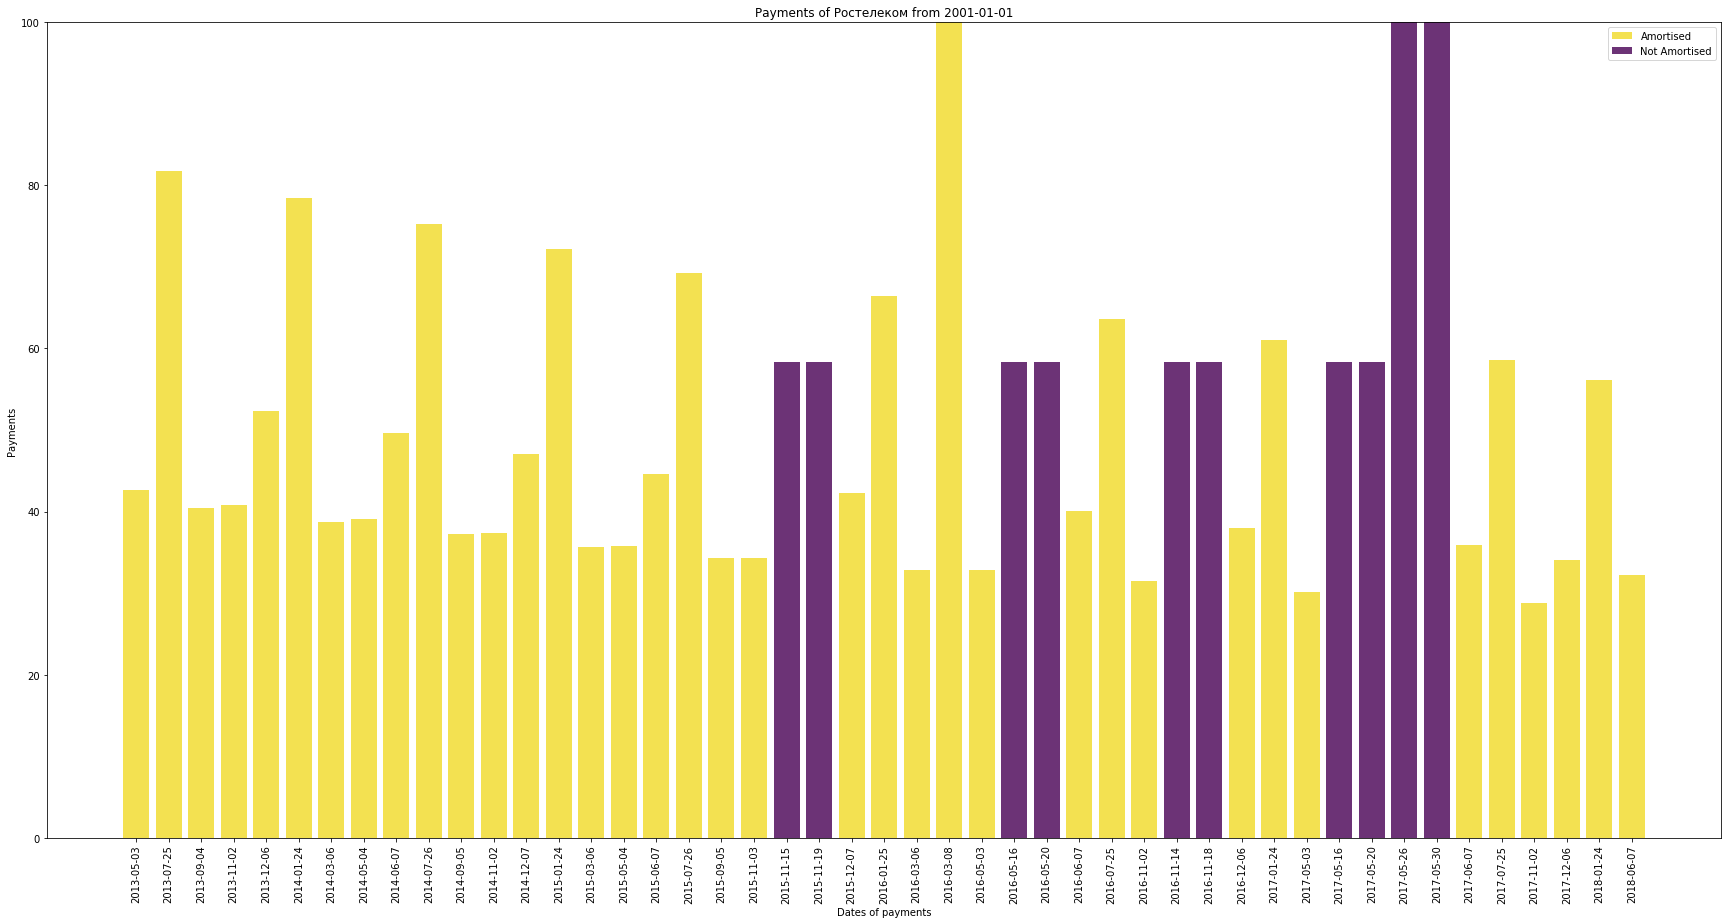

In [233]:
# task 2
import matplotlib.pyplot as plt
import numpy as np
dates_graph = portfolio_grouped.columns
amort = portfolio_grouped.iloc[0]
not_amort = portfolio_grouped.iloc[1]
plt.subplots(figsize=(30,15))
p1 = plt.bar(dates_graph, amort, width = 0.8, color="#f3e151")
p2 = plt.bar(dates_graph, not_amort, width = 0.8, bottom = amort, color="#6c3376")

plt.xlabel('Dates of payments')
plt.ylabel('Payments')
plt.xticks(rotation=90)
plt.title('Payments of '+ e + ' from ' + str(f))
b1 = portfolio_grouped[portfolio_grouped.index.get_level_values('Amortisation') == 'Amortised'].index[0]
b2 = portfolio_grouped[portfolio_grouped.index.get_level_values('Amortisation') == 'Not Amortised'].index[0]
plt.legend((p1[0], p2[0]), (str(b1), str(b2)))

payments_graph = plt.show(p1, p2)
payments_graph

# HW3 task3

In [221]:
from datetime import datetime

def year_delta(cur, base):
    return (datetime.strptime(cur, '%Y-%m-%d') - datetime.strptime(base, '%Y-%m-%d')).days / 365

def duration(times, coup, price, ytm):
    times = np.array(times)
    coup = np.array(coup)
    return np.exp(ytm * times) * coup * times / price

In [246]:
# issuer name and time are from variables e and f from the beginning of the HW3
import psycopg2
import getpass

a = input('User of database: ' )
b = input('Name of database: ' )
c = input('Host: ' )
d = input('Port: ' )
conn=psycopg2.connect(user=a, 
                      database=b, 
                      host=c,
                      port=d,
                      password=getpass.getpass('Insert password'))

query_ytm = """SELECT a."ISINCode" AS "ISIN", b."YIELD_ASK", b."ASK"
            FROM bonds.bond_description AS a
            JOIN bonds.quotes AS b 
            ON a."ISINCode" = b."ISIN" AND b."TIME" = '{f}' AND a."IssuerName" = '{e}'
            WHERE a."Status" != 'Погашен';""".format(f = '2014-05-16', e = 'Ростелеком')

data_ytm = pd.read_sql_query(query_ytm, conn) 
data_ytm = data_ytm.set_index('ISIN')
data_for_duration = portfolio.reset_index('Amortisation', drop = True)
result = pd.concat([data_for_duration, data_ytm], axis = 1, sort = True)
yield_nan_num = len(result[result.YIELD_ASK.isna()])
result = result[~result.YIELD_ASK.isna()] # keep those which has yield

if len(result) == 0: # Do we have something to plot
    print('Nothing to plot')

ISINs = []
durations = []

for j, i in result.iterrows():
    m, n = j, i
    y_times = list(map(lambda x: year_delta(x, '2014-05-16'), n.index[:-2]))
    ytm_value = n[-2] / 100
    price_value = n[-1]
    durations.append(duration(y_times, n[:-2], price_value, ytm_value).sum())
    ISINs.append(m)
    
ISIN_duration = pd.DataFrame(list(zip(ISINs, durations)), columns = ['ISIN', 'time']).sort_values('time')

User of database: postgres
Name of database: postgres
Host: Localhost
Port: 5432
Insert password········


In [247]:
ISIN_duration['ISIN'].values.tolist()
ISIN_duration['time'].values.tolist()

[3.44176806856705, 4.613062155939037, 5.552107265018201, 5.756408507615184]

<function matplotlib.pyplot.show(*args, **kw)>

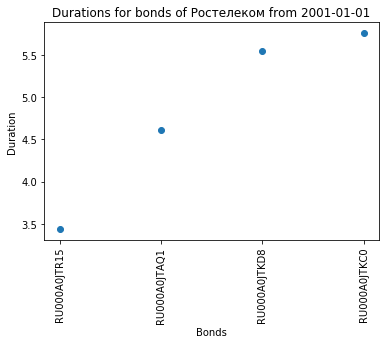

In [249]:
import matplotlib.pyplot as plt
p3 = plt.scatter(ISIN_duration['ISIN'].values, ISIN_duration['time'].values) 
plt.xlabel('Bonds')
plt.ylabel('Duration')
plt.xticks(rotation = 90)
plt.title('Durations for bonds of '+ str(e) + ' from ' + str(f))
plt.show

# Home Work 4

Two cells bellow are for testing, just swipe

In [225]:
# export table with payments of Rostelecom bonds to the given filepathway
from datetime import datetime
path_by_default = 'D:\\5\\IT\\risks\\hw4'
name_by_default = 'Matrix of payments of ' + str(x['ISSUER']) + ' from ' + str(x['DATE']) + \
                             ' updated ' + str(date.today()) + '.csv'
filename = path_by_default + '\\' + name_by_default
matrix_of_payments_ex.to_csv(filename, index = True)
# в Excel выделите весь первый столбец, перейдите в раздел "Данные", нажмите на "текст по столбцам", \
# поставьте флажок на разделителе "запятая". Вы прекрасны) и табличка тоже

In [226]:
# user settings for pathway and name
name_by_user = input('Insert name of table: ')
path_by_user = input('Insert path for table using backslash: ')
# for example to desktop: C:\Users\user\Desktop
matrix_of_payments_ex.to_csv((path_by_user + '\\' + name_by_user + '.csv'), index = True)
# в Excel выделите весь первый столбец, перейдите в раздел "Данные", нажмите на "текст по столбцам", \
# поставьте флажок на разделителе "запятая". Вы прекрасны) и табличка тоже

Insert name of table: table_1
Insert path for table using backslash: C:\Users\user\Desktop


# Function for exporting table from Jupyter depending on path and name preferences

In [227]:
# function to choose: export file with name and path by default or by user
# if want another emitent or from_date go above and change global vars "e" and "f" in "crazy" function
def export_table(type):
    type = int(input('Insert 1 if you want export and name file by default or \
    Insert 0  to export and name file by user settings'))
    if type == 1:
        from datetime import datetime
        path_by_default = 'D:\\5\\IT\\risks\\hw4'
        name_by_default = 'Matrix of payments of ' + str(x['ISSUER']) + ' from ' + str(x['DATE']) + \
                                     ' updated ' + str(date.today()) + '.csv'
        filename = path_by_default + '\\' + name_by_default
        matrix_of_payments_ex.to_csv(filename, index = True)
        next_instruction = 'в Excel выделите весь первый столбец, перейдите в раздел "Данные", ажмите на "текст по столбцам",\
        поставьте флажок на разделителе "запятая". Вы прекрасны) и табличка тоже'
        return path_by_default, name_by_default, next_instruction
    elif type == 0:
        name_by_user = input('Insert name of table: ')
        # for example table_1
        path_by_user = input('Insert path for table using backslash: ')
        # for example to desktop: C:\Users\user\Desktop
        matrix_of_payments_ex.to_csv((path_by_user + '\\' + name_by_user + '.csv'), index = True)
        next_instruction = 'в Excel выделите весь первый столбец, перейдите в раздел "Данные", нажмите на "текст по столбцам", \
        поставьте флажок на разделителе "запятая". Вы прекрасны) и табличка тоже'
        return path_by_user, name_by_user, next_instruction
    else:
        print('Insert correct type and try again, darling')

Examples of function usage

In [50]:
# example of export by default . for me default is folder which is written in 'return'
export_table(type)
# if want check output tables here 

Insert 1 if you want export and name file by default or     Insert 0  to export and name file by user settings1


('D:\\5\\IT\\risks\\hw4',
 'Matrix of payments of Ростелеком from 2001-01-01 updated 2019-12-20.csv',
 'в Excel выделите весь первый столбец, перейдите в раздел "Данные", ажмите на "текст по столбцам",        поставьте флажок на разделителе "запятая". Вы прекрасны) и табличка тоже')

In [53]:
# example of export by user settings
export_table(type)

Insert 1 if you want export and name file by default or     Insert 0  to export and name file by user settings0
Insert name of table: table_1
Insert path for table using backslash: C:\Users\user\Desktop


('C:\\Users\\user\\Desktop',
 'table_1',
 'в Excel выделите весь первый столбец, перейдите в раздел "Данные", нажмите на "текст по столбцам",         поставьте флажок на разделителе "запятая". Вы прекрасны) и табличка тоже')

In [55]:
# example of wrong input
export_table(type)

Insert 1 if you want export and name file by default or     Insert 0  to export and name file by user settings314159265359
Insert correct type and try again, darling


# pictures export

In [244]:
# function to choose: export pic with name and path by default or by user
# if want another emitent or from_date go above and change global vars "e" and "f" in "crazy" function
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
def export_picture(type):
    type = int(input('Insert 1 if you want export and name picture by default or \
    Insert 0  to export and name picture by user settings'))
    dates_graph = portfolio_grouped.columns
    amort = portfolio_grouped.iloc[0]
    not_amort = portfolio_grouped.iloc[1]
    plt.subplots(figsize=(20,12))
    p1 = plt.bar(dates_graph, amort, width = 0.8, color="#f3e151")
    p2 = plt.bar(dates_graph, not_amort, width = 0.8, bottom = amort, color="#6c3376")

    plt.xlabel('Dates of payments')
    plt.ylabel('Payments')
    plt.xticks(rotation=90)
    plt.title('Payments of '+ e + ' from ' + str(f))
    b1 = portfolio_grouped[portfolio_grouped.index.get_level_values('Amortisation') == 'Amortised'].index[0]
    b2 = portfolio_grouped[portfolio_grouped.index.get_level_values('Amortisation') == 'Not Amortised'].index[0]
    plt.legend((p1[0], p2[0]), (str(b1), str(b2)))

    if type == 1:
        from datetime import datetime
        path_by_default = 'D:\\5\\IT\\risks\\hw4'
        name_by_default = 'Payments of ' + str(x['ISSUER']) + ' from ' + str(x['DATE']) + \
                                     ' updated ' + str(date.today()) + '.png'
        filename = path_by_default + '\\' + name_by_default
        payments_graph = plt.savefig(filename)
        return path_by_default, name_by_default
    elif type == 0:
        name_by_user = input('Insert name of picture: ')
        # for example picture_1
        path_by_user = input('Insert path for picture using backslash: ')
        # for example to desktop: C:\Users\user\Desktop
        payments_graph = plt.savefig(path_by_user + '\\' + name_by_user + '.png')
        return path_by_user, name_by_user
    else:
        print('Insert correct type and try again, darling')

Examples of function exporting pictures

Insert 1 if you want export and name picture by default or     Insert 0  to export and name picture by user settings1


('D:\\5\\IT\\risks\\hw4',
 'Payments of Ростелеком from 2001-01-01 updated 2019-12-21.png')

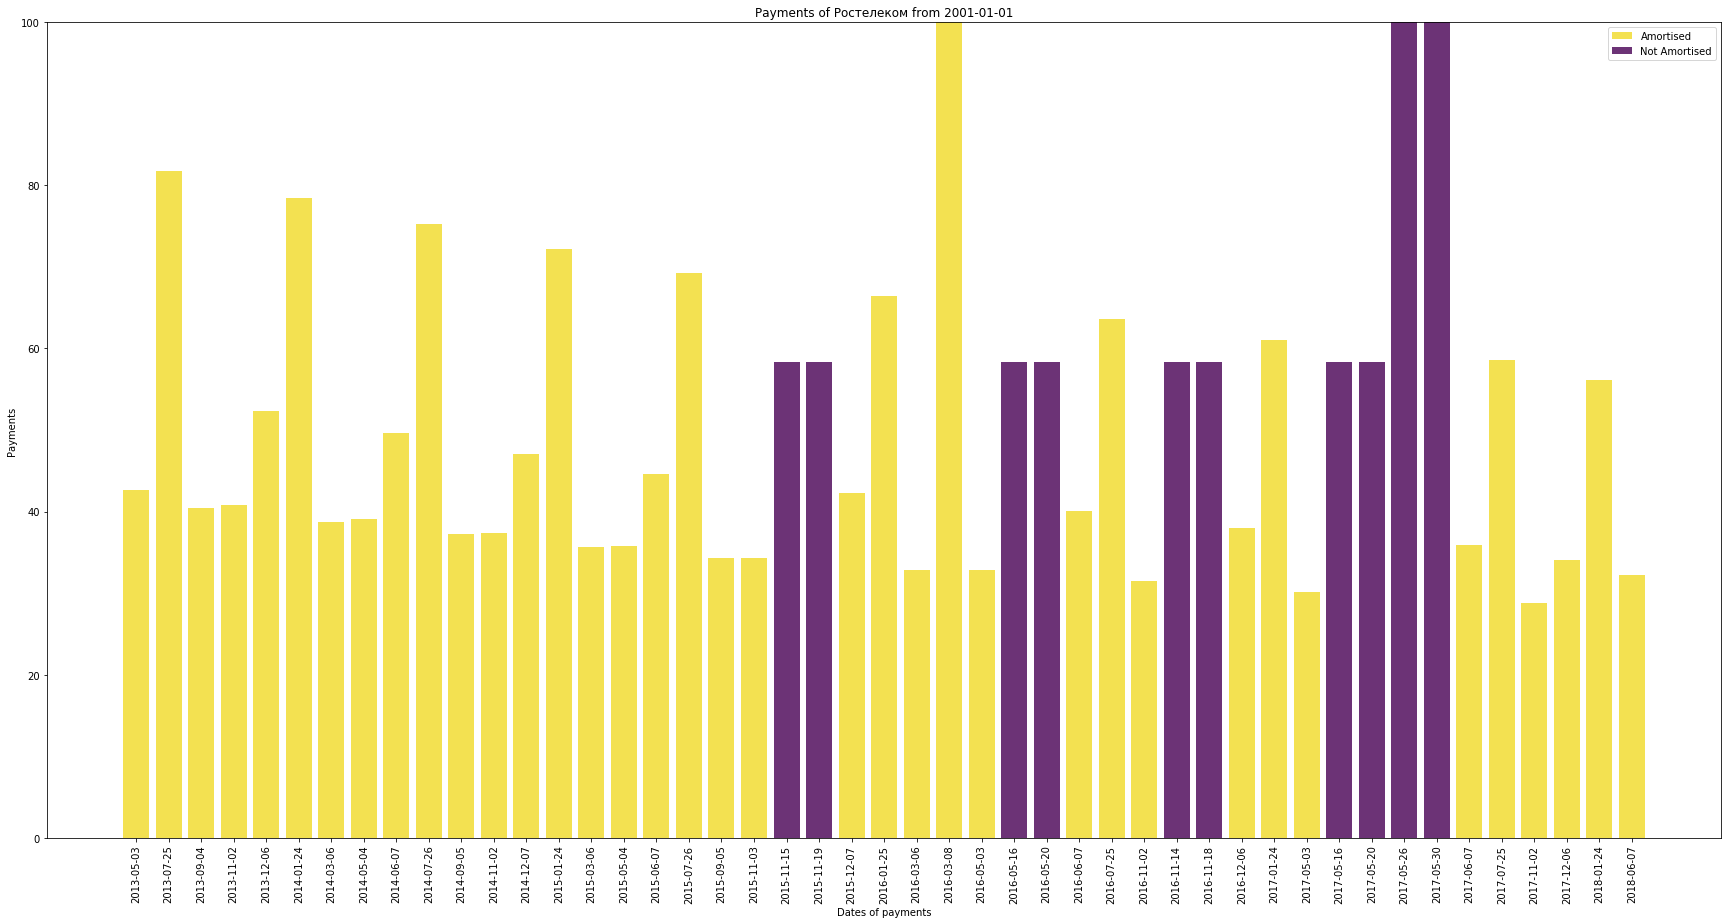

In [235]:
# by default. for me default is folder which is written in 'return'
export_picture(type)
# it creates picture in folder, but actually I don't know how to hide it from here. If u know please correct me)

Insert 1 if you want export and name picture by default or     Insert 0  to export and name picture by user settings0
Insert name of picture: pic_1
Insert path for picture using backslash: C:\Users\user\Desktop


('C:\\Users\\user\\Desktop', 'pic_1')

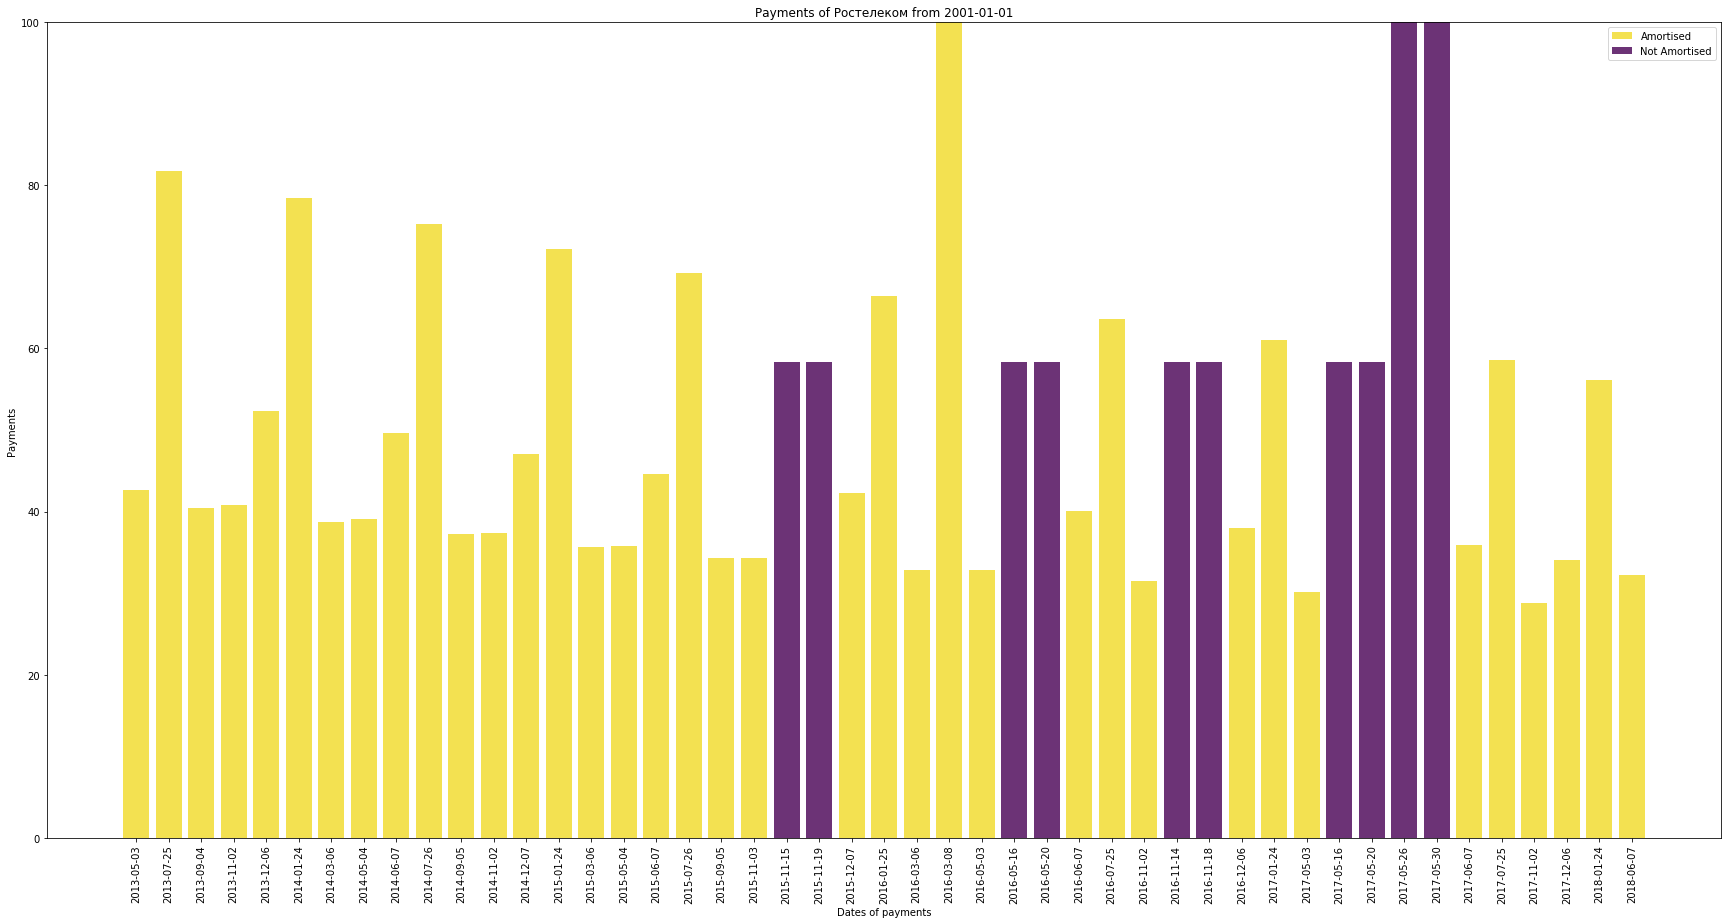

In [236]:
# by user's settings
export_picture(type)

Insert 1 if you want export and name picture by default or     Insert 0  to export and name picture by user settings27182818284
Insert correct type and try again, darling


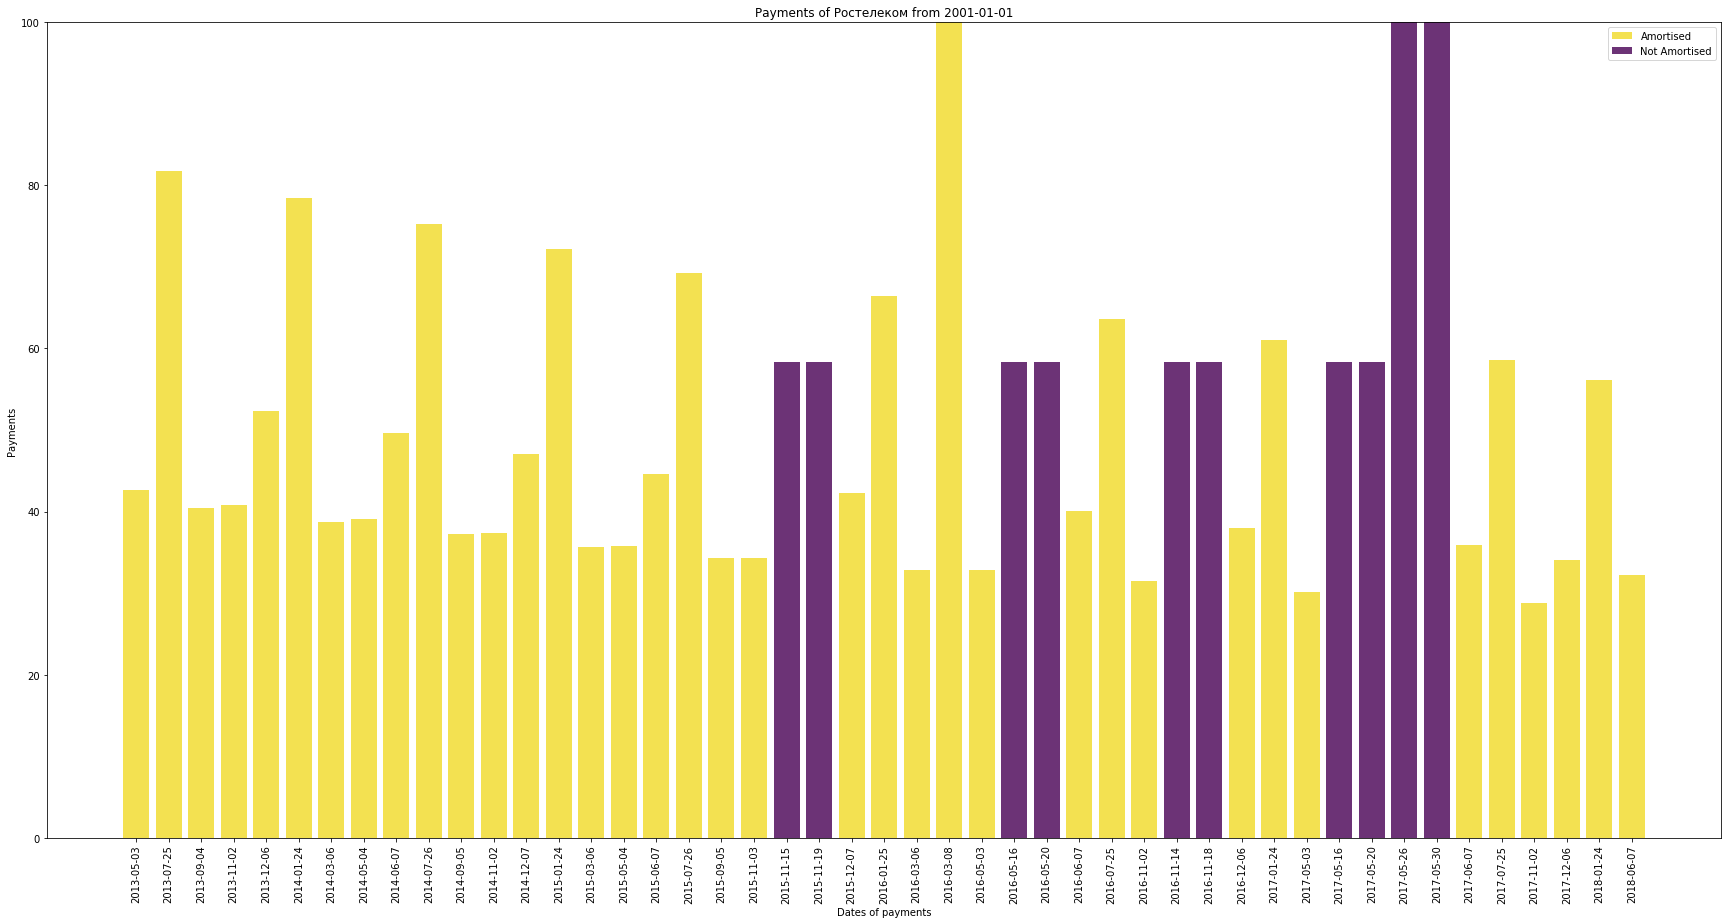

In [237]:
# wrong inputs. It draws, but will not save your creation of art anywhere
export_picture(type)

# Auto report in pdf 

Insert 1 if you want export and name file by default or     Insert 0  to export and name file by user settings1
Insert 1 if you want export and name file by default or     Insert 0  to export and name file by user settings1
Insert 1 if you want export and name picture by default or     Insert 0  to export and name picture by user settings1
Insert 1 if you want export and name picture by default or     Insert 0  to export and name picture by user settings1
Insert 1 if you want export and name picture by default or     Insert 0  to export and name picture by user settings1
Insert 1 if you want export and name picture by default or     Insert 0  to export and name picture by user settings1


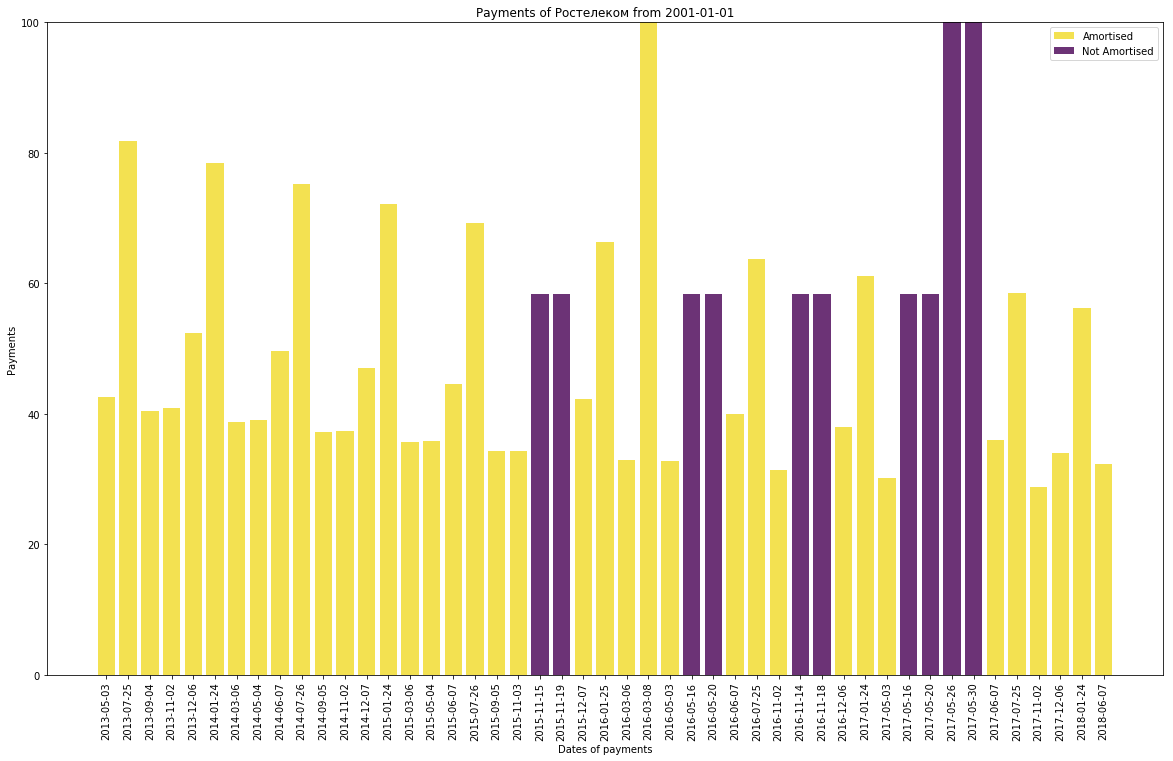

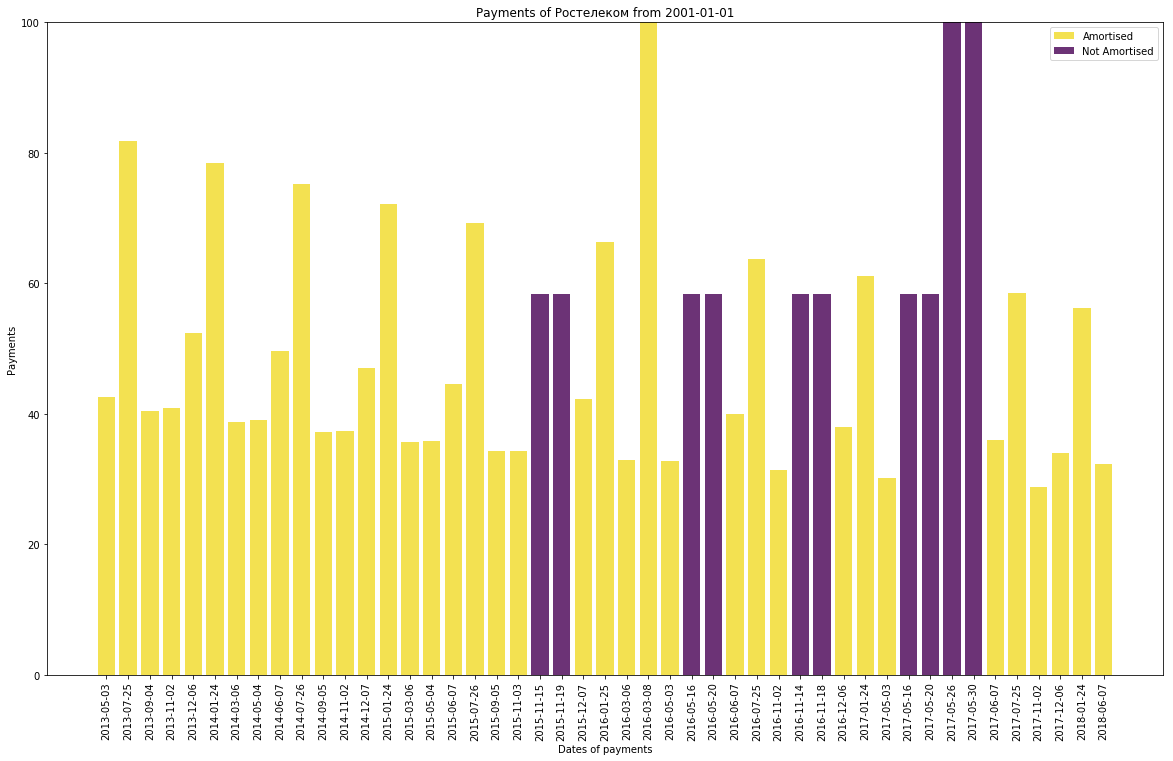

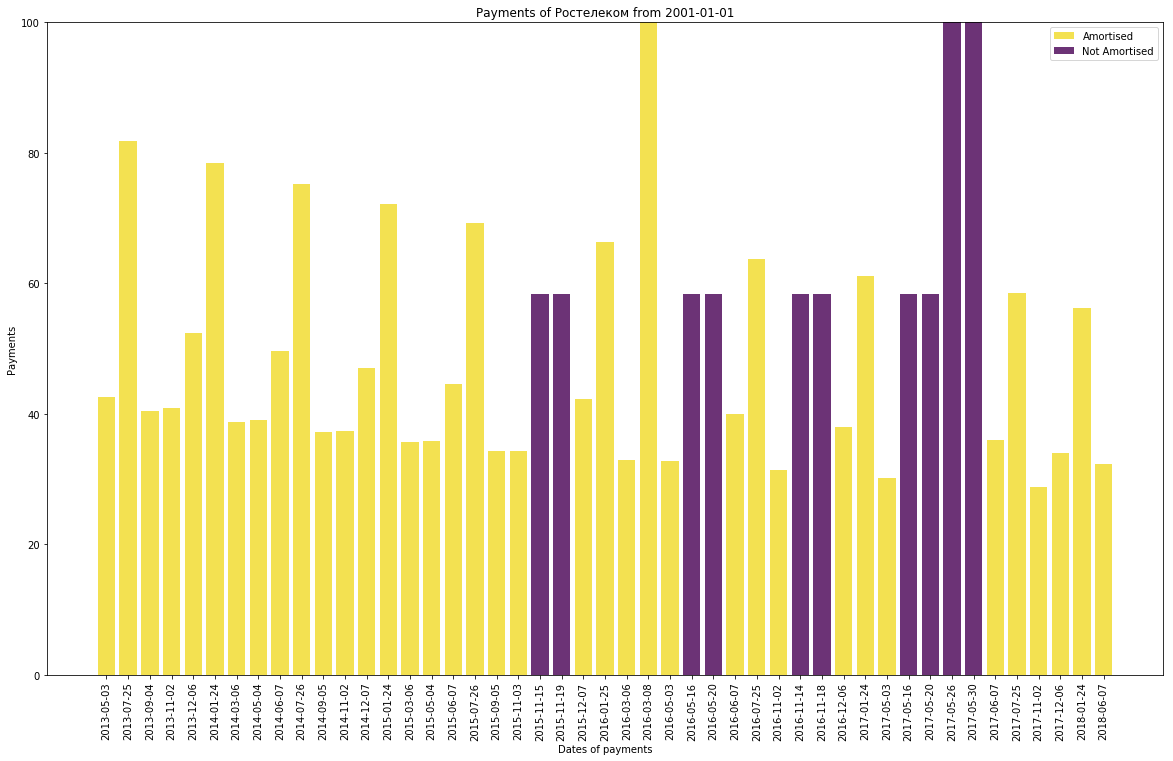

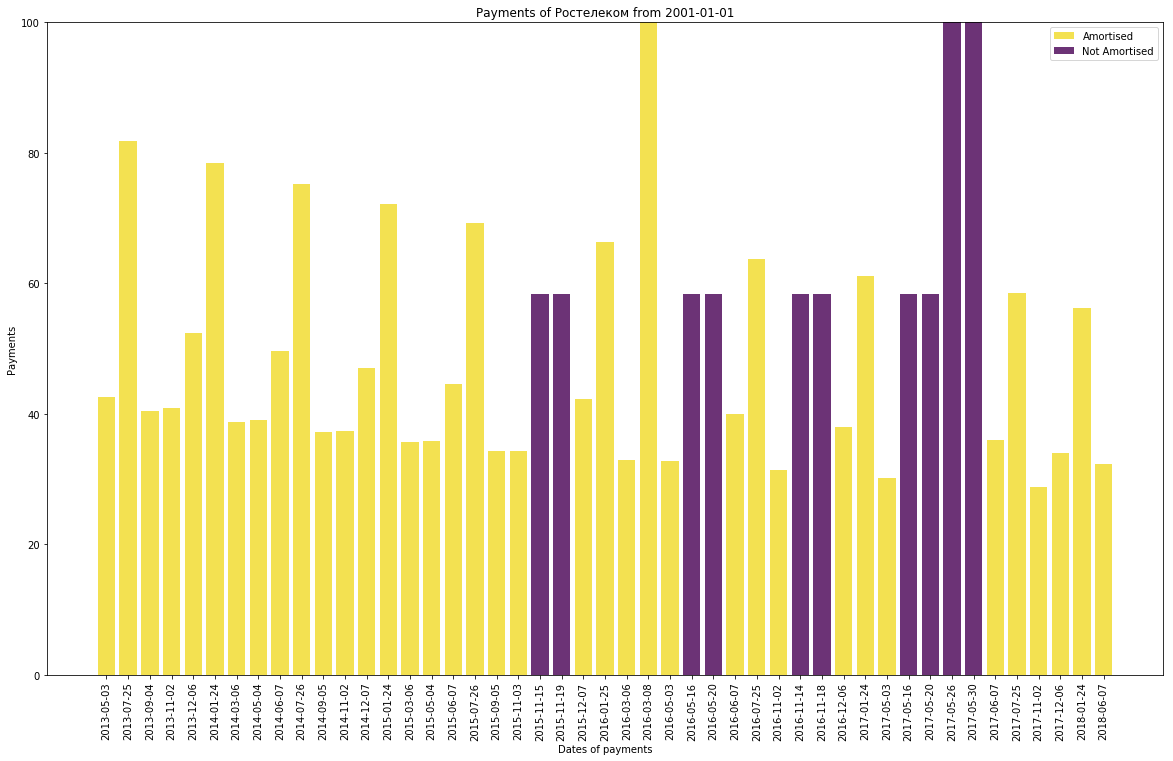

In [245]:
# Example for table and picture saved in folder and called by default. 
# We can add condition 'if' for 2 types of preferences about saving, but we're tired
from __future__ import print_function
from jinja2 import Environment, FileSystemLoader
from weasyprint import HTML, Document
import os

env = Environment(loader = FileSystemLoader('.'))
template = env.get_template("repo_Mirza.html") # Template in github
template_vars = {"title": "Отчет составлен by Aliev Mirzakishi",
                "INTRO": "Отчет содержит все старания и их результаты на тему облигаций. \
                В частности, график выплат по облигациям " + str(x['ISSUER']) + " с " + str(x['DATE']) \
                 + " рассчитанный и действительный на " + str(date.today()), 
                 "TABLE_DESC": "В таблице представлено " + export_table(type)[1] + ". Таблица находится в папке " + \
                 export_table(type)[0] + "(по всем облигациям (не сгруппированы по типу аморт./неаморт.))", 
                 "TABLE": portfolio.T.to_html(), 
                 "IMAGE_DESC": "На диаграмме изображены "+ export_picture(type)[1], 
                 "IMAGE": os.path.realpath(export_picture(type)[0] + '\\' + export_picture(type)[1])
                }

html_out = template.render(template_vars, presentational_hints=True)
HTML(string = html_out).write_pdf(export_picture(type)[0] + "\\" + "report " + str(x['ISSUER']) + " from " \
                                  + str(x['DATE']) + ".pdf", presentational_hints = True)


